# 自適應增強回歸(Adaptive Boost Regressor)

##### 先引入我們需要的packages

In [1]:
import os
import numpy as np
import random
import math
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Training Data

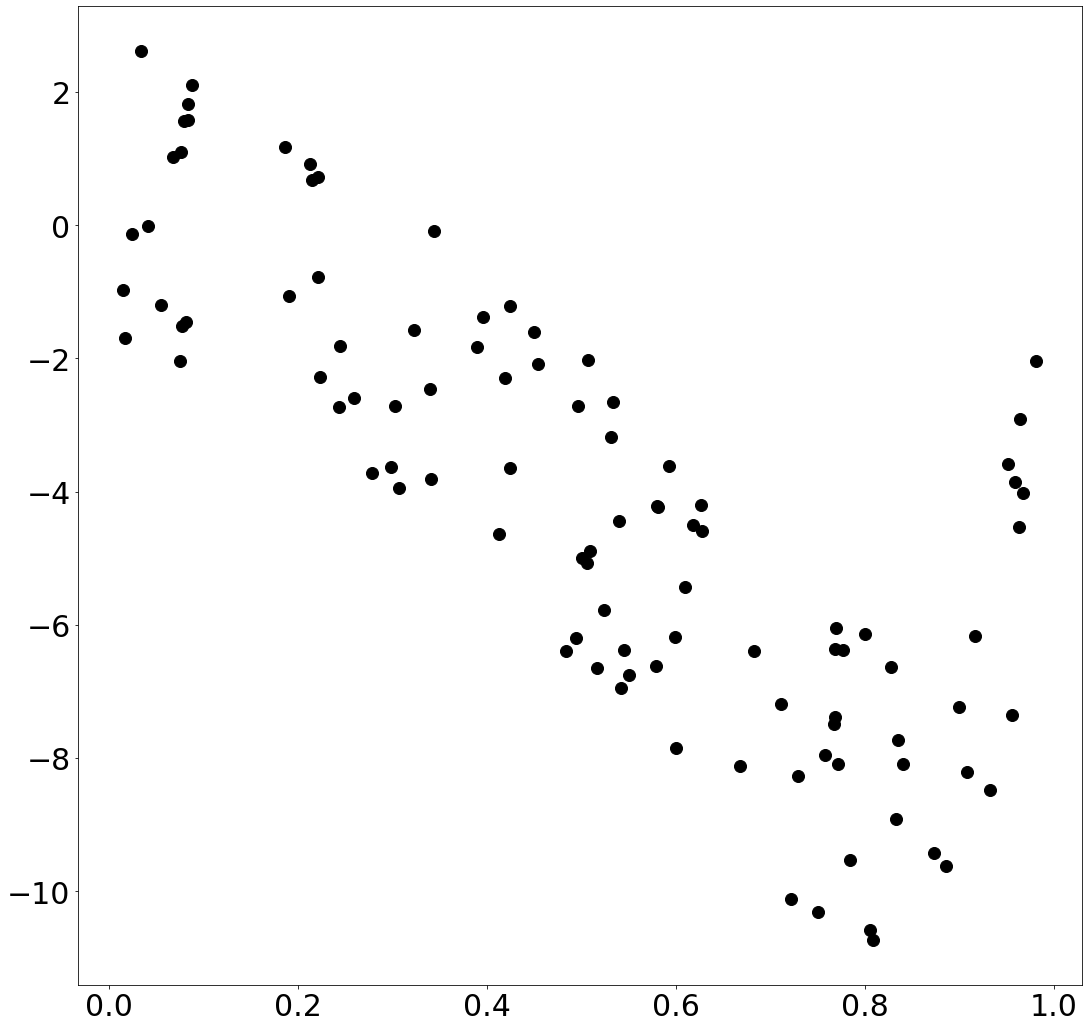

In [2]:
# p0~p9代表0次到9次方
p9,p8,p7,p6,p5,p4,p3,p2,p1,p0=1,3,5,7,9,-10,-8,-6,-4,-2
x=np.zeros(100)
y=np.zeros(100)
# 隨機產生數據點
for i in range(0,len(x)):
    x[i]+=random.random()
    y[i]+=random.random()*5
power=[p9,p8,p7,p6,p5,p4,p3,p2,p1,p0]
for i in range(0,len(power)):
    y+=power[len(power)-i-1]*(x**i)
# 視覺化
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Polynomial Kernel

In [3]:
def Polynomial_kernel(x,xx,power,gamma,zeta):
    return (zeta+gamma*np.outer(x,xx))**power

# Support Vector Regression

In [4]:
def SVR(x,y,D,sss):
    N=100
    c=9
    gamma=1
    zeta=1
    t=2
    CC=100
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    x_plot=np.linspace(min(x),max(x),100)
    K_plot=Polynomial_kernel(x_plot,x,c,gamma,zeta)
    # 二次規劃(可比照公式)
    Q = cvxopt.matrix(np.concatenate([np.concatenate([K,-K],axis=0),np.concatenate([-K,K],axis=0)],axis=1))
    u = cvxopt.matrix(np.concatenate([D*(np.ones(N)*t-y),D*(np.ones(N)*t+y)]),(2*N,1))
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(2*N)* 1.),np.diag(np.ones(2*N)* -1.)]))
    h = cvxopt.matrix(np.concatenate([CC*np.concatenate([D,D])*np.ones(2*N),np.zeros(2*N)]))
    A = cvxopt.matrix(np.concatenate([np.ones(N),-np.ones(N)]),(1,2*N))
    b = cvxopt.matrix(0.0)
    # 利用cvxopt套件求解
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    # 求出alpha值
    a=np.array(cvxopt.solvers.qp(Q, u, G, h, A, b)['x']).flatten()
    # a(U)-a(D)
    aa=a[:N]-a[N:2*N]
    # 找出上界support vector
    for i in range(0,N):
        if(a[i]>10**-6):
            U_SV=i
            break
    # 找出下界support vector
    for i in range(N,2*N):
        if(a[i]>10**-6):
            D_SV=i
            break
    # 計算上界回歸線邊界
    Com=0
    for i in range(0,N):
        if(abs(aa[i])>1e-6):
            Com+=aa[i]*K[i,U_SV]
    b_U=y[U_SV]-Com
    # 計算下界回歸線邊界
    Com=0
    for i in range(0,N):
        if(abs(aa[i])>1e-6):
            Com+=aa[i]*K[i,D_SV-N]
    b_D=y[D_SV-N]-Com
    y_pred_plot=np.dot(K_plot,aa)+(b_U+b_D)/2
    # 視覺化
    y_pred=np.dot(K,aa)+(b_U+b_D)/2
    error=sum(D/sum(D)*(abs(y_pred-y)>t))
    if(error>0.5):
        return 0,0,0,0,0,0
    else:
        plt.plot(x_plot,y_pred_plot,"-",linewidth=6,label=str(sss+1)+" iteration")
        alpha_temp=0.5*np.log((1-error)/error)
        D[abs(y_pred-y)>t]=D[abs(y_pred-y)>t]*np.exp(alpha_temp)
        D[abs(y_pred-y)<=t]=D[abs(y_pred-y)<=t]*np.exp(-alpha_temp)
        return alpha_temp,D,K,K_plot,aa,(b_U+b_D)/2

# Adaptive Boost

The 1 iteration MSE = 2.3516827924061263
The 2 iteration MSE = 2.65934581045114
The 3 iteration MSE = 7.290477527608866
Adaptive Boost Regressor MSE = 2.3430099558328483


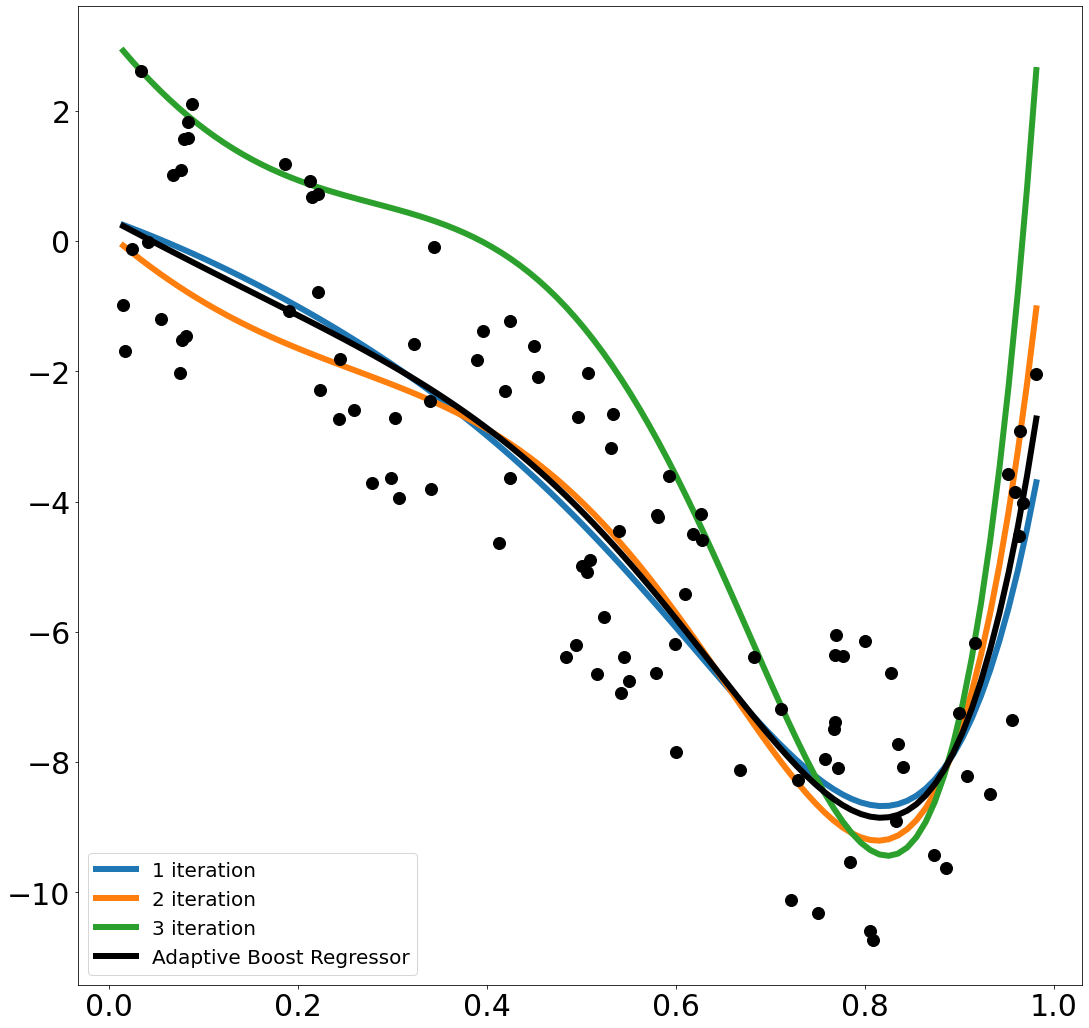

In [5]:
T=10
N=100
D=np.ones(N)
alpha=np.zeros(T)
H=np.zeros(N)
H_plot=np.zeros(100)
plt.rcParams["figure.figsize"] = (18,18)
for i in range(0,T):
    alpha[i],D,K,K_plot,a,b=SVR(x,y,D,i)
    if(alpha[i]==0):
        break
    H+=alpha[i]*(np.dot(K,a)+b)
    H_plot+=alpha[i]*(np.dot(K_plot,a)+b)
    print("The",i+1,"iteration MSE =", sum((np.dot(K,a)+b-y)**2)/N)
H/=sum(alpha)
H_plot/=sum(alpha)
plt.plot(np.linspace(min(x),max(x),100),H_plot,"k-",linewidth=6,label="Adaptive Boost Regressor")
print("Adaptive Boost Regressor MSE =", sum((H-y)**2)/N)
plt.plot(x,y,"ko",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()